# Train simple RNN model on d3d_100 dataset

In [1]:
import logging
import shutil
import errno
import tempfile
from os import environ
from os.path import join

In [2]:
environ["CUDA_VISIBLE_DEVICES"] = "1"

In [3]:
import numpy as np

import torch
from torch.utils.data import DataLoader
import torch.nn.functional as F
import torch.nn as nn
import torch.optim as optim

from tqdm import tqdm

import sys
sys.path.append("/home/rkube/repos/frnn-loader")

import matplotlib.pyplot as plt

In [4]:
from frnn_loader.backends.fetchers import fetcher_d3d_v1
from frnn_loader.backends.backend_hdf5 import backend_hdf5
from frnn_loader.primitives.filters import filter_ip_thresh
from frnn_loader.primitives.resamplers import resampler_causal
from frnn_loader.primitives.signal import signal_0d
from frnn_loader.primitives.normalizers import mean_std_normalizer
from frnn_loader.loaders.frnn_dataset_disk import shot_dataset_disk
from frnn_loader.loaders.frnn_multi_dataset import frnn_multi_dataset
from frnn_loader.loaders.frnn_loader import batched_random_sequence_sampler


from frnn_loader.utils.errors import SignalCorruptedError, NotDownloadedError

In [47]:
# Directory where all project data files are to be stored
root = "/projects/FRNN/frnn_loader"

# 1/ Describe the dataset
predictor_tags = (
    "q95",
    "efsli",
    "ipspr15V",
    "efsbetan",
    "efswmhd",
    "dssdenest",
    "pradcore",
    "pradedge",
    "bmspinj",
    "bmstinj",
    "ipsiptargt",
    "ipeecoil"
)
predictor_list = tuple([signal_0d(tag) for tag in predictor_tags])

# Contains a list of shots that are non-disruptive
shotlist_clear = "d3d_clear_100.txt"
# Contains a list of shots that are disruptive
shotlist_disrupt = "d3d_disrupt_100.txt"

In [48]:
sig_q95 = signal_0d("q95")

In [54]:
isinstance(predictor_list, tuple)

True

In [55]:
sig_q95 in predictor_list

True

In [57]:
predictor_list[0] == signal_0d("q95")

True

In [62]:
predictor_list.index(signal_0d("qmin"))

ValueError: tuple.index(x): x not in tuple

In [44]:
predictor_tags[0]

'q95'

In [6]:
cuda = torch.device("cuda:1")

In [7]:
# Instantiate the filter we use to crimp the shot times
dt = 1.0 # Time used for resampling
ip_filter = filter_ip_thresh(0.2)
signal_ip = signal_0d("ipspr15V")
my_backend = backend_hdf5(root)
my_fetcher = fetcher_d3d_v1()

# These shots don't have enough data and are unusable
# Several of them are also not disruptive but die to to carbon motes or other hardware failures
skip_shots = [167516, 167517, 167548, 168439, 168441, 168450, 168484, 168500, 168442, 168443, 168483, 168485, 168486]

In [8]:
shotdict = {}

with open(join(root, "..", "shot_lists", shotlist_clear), "r") as fp:
    for line in tqdm(fp.readlines()):
        # Convert shotnr to int and ttd to float
        shotnr, ttd = [trf(val) for trf, val in zip([int, float], line.split())]
        
        # Run the Ip filter over the current shot.
        # For this we need the shot raw-data. Ask the backend to load it.
        try:
            tb, signal_data = my_backend.load(signal_ip.info, shotnr)
        except NotDownloadedError:
            # IF it's now downloaded a NotDownloadedError is thrown.
            # Then use the fetcher to manually download it
            tb, _, signal_data, _, _, _ = my_fetcher.fetch(signal_ip.info, shotnr)
            my_backend.store(signal_ip.info, shotnr, tb, signal_data)
        # Some shots in d3d_clear_100 have no plasma. Skip these shots.
        if shotnr in skip_shots:
            continue
        try:
            tmin, tmax = ip_filter(tb, signal_data)
        except SignalCorruptedError as err:
            print(f"--- Shot {shotnr}: Error: ", err)
            continue
            
        shotdict.update(
            {
                shotnr: {
                    "tmin": tmin,
                    "tmax": tmax,
                    "is_disruptive": False,
                    "t_disrupt": -1.0,
                }
            }
        )

 21%|█████████████████████▏                                                                               | 21/100 [00:00<00:02, 30.30it/s]

--- Shot 167515: Error:  filter_ip_thresh - self.ip_thresh=0.2: Bad signal: Fewer than 100 points are valid.


 85%|█████████████████████████████████████████████████████████████████████████████████████▊               | 85/100 [00:01<00:00, 64.58it/s]

--- Shot 168440: Error:  filter_ip_thresh - self.ip_thresh=0.2: Bad signal: Fewer than 100 points are valid.
--- Shot 168444: Error:  filter_ip_thresh - self.ip_thresh=0.2: Bad signal: Fewer than 100 points are valid.
--- Shot 168487: Error:  filter_ip_thresh - self.ip_thresh=0.2: Bad signal: Fewer than 100 points are valid.
--- Shot 168488: Error:  filter_ip_thresh - self.ip_thresh=0.2: Bad signal: Fewer than 100 points are valid.
--- Shot 168490: Error:  filter_ip_thresh - self.ip_thresh=0.2: Bad signal: Fewer than 100 points are valid.
--- Shot 168491: Error:  filter_ip_thresh - self.ip_thresh=0.2: Bad signal: Fewer than 100 points are valid.


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 49.90it/s]


In [9]:
with open(join(root, "..", "shot_lists", shotlist_disrupt), "r") as fp:
    for line in tqdm(fp.readlines()):
        # Convert shotnr to int and ttd to float
        shotnr, ttd = [trf(val) for trf, val in zip([int, float], line.split())]
        
        # Run the Ip filter over the current shot.
        # For this we need the shot raw-data. Ask the backend to load it.
        try:
            tb, signal_data = my_backend.load(signal_ip.info, shotnr)
        except NotDownloadedError:
            # IF it's now downloaded a NotDownloadedError is thrown.
            # Then use the fetcher to manually download it
            tb, _, signal_data, _, _, _ = my_fetcher.fetch(signal_ip.info, shotnr)
            my_backend.store(signal_ip.info, shotnr, tb, signal_data)
        
        if shotnr in skip_shots:
            continue
        # ttd is given in seconds in the text files. Convert it to milliseconds
        ttd = ttd * 1e3
        shotdict.update(
            {
                shotnr: {
                    "tmin": tmin,
                    "tmax": ttd,
                    "is_disruptive": True,
                    "t_disrupt": ttd,
                }
            }
        )


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:01<00:00, 88.62it/s]


In [10]:
#########################################################################################################
#
# Next we create a list of datasets for all shots.
# The shots are cut to the time intervals defined by tmin and tmax
# A normalizer is calculated from these datasets.
# After the normalizer has been calculated the hdf5 files generated by
# these dataset are to be deleted using ds.delete_data_file

dset_unnormalized_list = []
for shotnr in tqdm(shotdict.keys()):
    # Resample all signals over the valid intervals
    my_resampler = resampler_causal(0.0, shotdict[shotnr]["tmax"], dt)

    ds = shot_dataset_disk(
        shotnr,
        predictors=predictor_list,
        resampler=my_resampler,
        backend_file=my_backend,
        fetcher=my_fetcher,
        root=root,
        download=True,
        normalizer=None,
        is_disruptive=shotdict[shotnr]["is_disruptive"],
        target=None,
        #target = target_TTD(dt, shotdict[shotnr][is_disruptive]),
        dtype=torch.float32)

    dset_unnormalized_list.append(ds)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 180/180 [00:32<00:00,  5.61it/s]


[167480,
 167487,
 167488,
 167492,
 167494,
 167496,
 167497,
 167498,
 167500,
 167501,
 167503,
 167505,
 167550,
 167556,
 167557,
 167558,
 167559,
 167560,
 167561,
 167562,
 167564,
 167565,
 167566,
 167586,
 167587,
 167588,
 167590,
 167591,
 167592,
 167593,
 167594,
 167595,
 167596,
 167597,
 167598,
 167599,
 167610,
 167611,
 167612,
 167613,
 167614,
 167615,
 167616,
 167617,
 167619,
 167621,
 167622,
 168445,
 168446,
 168447,
 168448,
 168449,
 168489,
 168492,
 168493,
 168494,
 168495,
 168501,
 168502,
 168503,
 168505,
 168506,
 168507,
 168508,
 168509,
 168510,
 168511,
 168512,
 168513,
 168514,
 168515,
 168517,
 168518,
 168520,
 168521,
 168522,
 168527,
 168528,
 168531,
 168532,
 168533,
 168538,
 168539,
 168540,
 168541,
 168542,
 168543,
 168545,
 168546,
 168547,
 168549,
 168550,
 168552,
 168553,
 168555]

In [18]:
print(ds.is_disruptive)
target = ds[:][1]


True


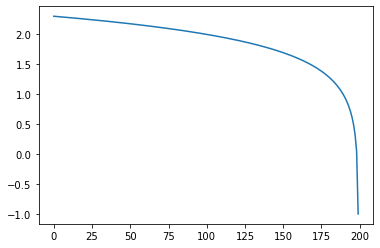

In [21]:
plt.plot(target[-200:])

In [23]:
type(ds.predictors[0])

frnn_loader.primitives.signal.signal_0d

In [24]:
dir(ds.predictors[0])

['__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 'fetch_data',
 'info',
 'load_data',
 'num_channels',
 'root',
 'tag']

In [33]:
[p for p in ds.predictors if p.num_channels==1]

[D3D: Q95 safety factor,
 D3D: Internal inductance,
 D3D: Plasma Current,
 D3D: Normalized beta,
 D3D: Stored Energy,
 D3D: Plasma Density,
 D3D: Radiated Power Core,
 D3D: Radiated Power Edge,
 D3D: Beam input power,
 D3D: Beam input torque,
 D3D: Plasma current target,
 D3D: Plasma current error]

In [34]:
ds.predictors[0] == ds.predictors[0]

True

In [36]:
dset_unnormalized_list[0].predictors[0] == dset_unnormalized_list[1].predictors[0]

True

In [ ]:
#########################################################################################################
#
# With all datasets cropped to the correct time in place we continue by calculating the normalization.
# Do this using multi-processing
my_normalizer = mean_std_normalizer()
my_normalizer.fit(dset_unnormalized_list)

print(my_normalizer.mean_all)
print(my_normalizer.std_all)

In [ ]:
# With a normalizer at hand, we can now safely delete the datafiles from the
# un-normalized shots.
# Then re-instantiate the datasets using the trained normalizer
dset_normalized_list = []
for shotnr in tqdm(shotdict.keys()):

    # Resample all signals over the valid intervals
    my_resampler = resampler_causal(0.0, shotdict[shotnr]["tmax"], 1.0)

    ds = shot_dataset_disk(
        shotnr,
        predictors=predictor_list,
        resampler=my_resampler,
        backend_file=my_backend,
        fetcher=my_fetcher,
        root=root,
        download=True,
        normalizer=my_normalizer,
        is_disruptive=shotdict[shotnr]["is_disruptive"],
        dtype=torch.float32,
    )
    dset_normalized_list.append(ds)

dset_work = frnn_multi_dataset(dset_normalized_list)

In [ ]:
for i in range(4):
    print(dset_work[i][:][0].shape)
    print(dset_work[i][:][1].shape)

In [ ]:
for i in range(4):
    plt.figure()
    plt.subplot(1,2,1)
    plt.plot(dset_work[i][:][0]);
    plt.subplot(1,2,2)
    plt.plot(dset_work[i][:][1]);

In [ ]:
def my_collate_fn(input):
    """Reshape list of inputs to torch.tensor

    Input is a list of length 1. The only element is the list returned
    by frnn_multi_dataset.__getitem__

    We
    """
    X_vals = torch.stack([t[0] for t in input[0]])
    Y_vals = torch.stack([t[1] for t in input[0]])

    return X_vals, Y_vals

In [ ]:
# This sampler pulls a batch of `batch_size` sequences, each of length `seq_length
# from the dataset. The sequences start at random places and are uniformly distributed
# over the shots of the dataset.
my_sampler = batched_random_sequence_sampler(dset_work, seq_length=400, batch_size=32)
# Default pytorch dataloader. Batch shape is defined through my_sampler
# my_collate_fn is used to transform output from dataset.__getitem__ to a torch.tensor
my_loader = DataLoader(dset_work, sampler=my_sampler, collate_fn=my_collate_fn)

In [ ]:
# Set up a simple model. Use parameters in plasma-python/examples/conf.yaml
# And model construction written in plasma/models/builder.py, build_model

class SimpleLSTM(nn.Module):
    """Simple LSTM for TTD prediction."""
    def __init__(self, size_in):
        super(SimpleLSTM, self).__init__()
        self.size_in = size_in
        self.pre_rnn = nn.Sequential(
            nn.Linear(self.size_in, 128),
            nn.ReLU(),
            nn.Linear(128, 128//2),
            nn.ReLU(),
            nn.Linear(128//2, 128//4)
        )
        
        # https://pytorch.org/docs/stable/generated/torch.nn.LSTM.html?highlight=lstm#torch.nn.LSTM
        self.lstm = nn.LSTM(128//4, 32, num_layers=2, batch_first=True)
        self.final = nn.Linear(32, 1)
        
    def forward(self, x):
        x = self.pre_rnn(x)
        # LSTM has 3 outputs.
        # 1. X
        # 2. h
        # 3. c
        x, h_c = self.lstm(x)
        x = self.final(x)
        
        return x

In [ ]:
model = SimpleLSTM(12).cuda()
print(model)

In [ ]:
# Set up training:
num_epochs = 30

# Loss function
loss_fn = nn.MSELoss()
# Optimizer
opt = optim.Adam(model.parameters(), weight_decay=1e-4)

In [ ]:
for num_batch, XY in enumerate(my_loader):
    X, Y = XY
    print(X.shape)
    print(Y.shape)
    break

In [ ]:
# Iterate over training set
loss_vec = np.zeros(num_epochs)

for epoch in range(num_epochs):
    loss_epoch = 0.0
    num_batches = 0
    for num_batch, XY in enumerate(my_loader):
        X, Y = XY
        X = X.cuda()
        Y = Y.cuda()
        opt.zero_grad()
        
        output = model(X[:, :-1, :])
        loss = loss_fn(output, Y[:, 1:, :])
        loss.backward()
        opt.step()
        num_batches += 1

        loss_epoch += loss.item()
    if epoch % 10 == 0:   
        print(f"Epoch {(epoch+1):3d}: loss={(loss_epoch):8.6e}")
    loss_vec[epoch] = loss_epoch
    
plt.plot(loss_vec)
plt.ylabel("MSE loss")

In [ ]:
plt.plot(loss_vec[1:])

In [ ]:
i = 0
for xy in my_loader:
    X, Y = XY
    print(X.shape)
    i = i + 1 #break
    break
print(i)
Y_pred = model(X.cuda()).cpu()

In [ ]:
X.shape

In [ ]:
for i in range(Y.shape[0]):
    plt.figure()
    plt.plot(Y[i, 1:, 0].detach().cpu().numpy())
    plt.plot(Y_pred[i, 1:, 0].detach().cpu().numpy())